# F1 Multi-Agent Competitive Race Simulator

This notebook implements a competitive racing simulator where AI agents race **against each other**.

## MVP Objectives
1. Create a competitive race environment with 4 corners and 2 drivers
2. Implement strategic decision-making: overtaking risk, incident probability
3. Track competitive metrics: positions, gaps, overtakes
4. Foundation for MARL algorithm comparison (DQN, PPO, MADDPG)

## Key Features
- **Multi-agent competition**: 2 drivers racing simultaneously
- **Strategic decisions**: Overtaking risk levels per corner
- **Stochastic elements**: Incident probability based on risk and corner difficulty
- **Positional dynamics**: Gap tracking, position changes, overtaking maneuvers

## 1. Import Required Libraries

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Optional
from dataclasses import dataclass
from enum import Enum
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)  # For reproducibility

## 2. Define Track with Competitive Corners

Each corner has:
- Base lap time component
- Difficulty (affects incident probability when taking risks)
- Overtaking probability (some corners better for overtaking)

In [108]:
class Corner:
    """Represents a corner on the racing track"""
    def __init__(self, corner_id: int, base_time: float, difficulty: float, 
                 overtake_probability: float):
        self.corner_id = corner_id
        self.base_time = base_time  # Base time to complete corner + straight (seconds)
        self.base_ticks = int(base_time * 100)  # Convert to ticks at 100Hz
        self.difficulty = difficulty  # 0-1, affects incident risk
        self.overtake_probability = overtake_probability  # Base probability of successful overtake
        
    def __repr__(self):
        return (f"Corner {self.corner_id}: time={self.base_time}s ({self.base_ticks} ticks), "
                f"diff={self.difficulty:.2f}, overtake_prob={self.overtake_probability:.2f}")


class RacingTrack:
    """4-corner competitive racing track"""
    def __init__(self):
        # Define 4 corners with varying characteristics
        self.corners = [
            Corner(1, base_time=18.5, difficulty=0.05, overtake_probability=0.25),
            Corner(2, base_time=22.0, difficulty=0.08, overtake_probability=0.05),  # Slow, risky
            Corner(3, base_time=15.0, difficulty=0.03, overtake_probability=0.15),
            Corner(4, base_time=20.0, difficulty=0.06, overtake_probability=0.10),
        ]
        self.num_corners = len(self.corners)
        self.base_lap_time = sum(c.base_time for c in self.corners)
        self.base_lap_ticks = sum(c.base_ticks for c in self.corners)
        
    def get_corner(self, corner_idx: int) -> Corner:
        """Get corner by index (0-3)"""
        return self.corners[corner_idx % self.num_corners]
    
    def __repr__(self):
        return (f"RacingTrack: {self.num_corners} corners, "
                f"base lap time: {self.base_lap_time:.2f}s ({self.base_lap_ticks} ticks @ 100Hz)")

## 3. Define Driver State and Actions

Each driver can make strategic decisions at each corner.

In [109]:
class RiskLevel(Enum):
    """Risk level for overtaking attempts"""
    CONSERVATIVE = 0  # Low risk, low reward
    NORMAL = 1        # Balanced
    AGGRESSIVE = 2    # High risk, high reward


@dataclass
class DriverState:
    """Represents the current state of a driver"""
    driver_id: int
    name: str
    position: int  # 1st, 2nd, etc.
    lap: int
    corner_idx: int  # Current corner (0-3)
    ticks_in_corner: int  # How many ticks into current corner
    total_ticks: int  # Cumulative race time in ticks (100Hz = 0.01s per tick)
    gap_to_ahead: Optional[float] = None  # Gap to car ahead (seconds), None if leading
    gap_to_behind: Optional[float] = None  # Gap to car behind (seconds), None if last
    incidents: int = 0  # Number of incidents
    overtakes_made: int = 0
    overtakes_received: int = 0
    corner_time_remaining: int = 0  # Ticks remaining in current corner
    
    @property
    def total_time(self) -> float:
        """Convert ticks to seconds"""
        return self.total_ticks * 0.01
    
    def __repr__(self):
        return (f"Driver {self.name} (P{self.position}): Lap {self.lap}, "
                f"Corner {self.corner_idx}, Time {self.total_time:.2f}s")


@dataclass
class DriverAction:
    """Actions a driver can take at a corner"""
    risk_level: RiskLevel  # How aggressive to be
    attempt_overtake: bool  # Whether to attempt overtaking car ahead

## 4. Race Simulator Engine

The core simulation engine that processes each tick at 100Hz (0.01 seconds per tick).

Drivers make decisions at corner entry, then the simulator processes ticks until corner completion.

In [110]:
class RaceSimulator:
    """Simulates competitive multi-agent racing at 100Hz"""
    
    TICK_RATE = 100  # Hz
    TICK_DURATION = 0.01  # seconds per tick
    
    # Risk modifiers
    RISK_TIME_BONUS = {  # Time reduction per risk level (seconds)
        RiskLevel.CONSERVATIVE: 0.0,
        RiskLevel.NORMAL: 0.1,
        RiskLevel.AGGRESSIVE: 0.25
    }
    
    RISK_INCIDENT_MULT = {  # Incident probability multiplier
        RiskLevel.CONSERVATIVE: 0.3,
        RiskLevel.NORMAL: 1.0,
        RiskLevel.AGGRESSIVE: 2.5
    }
    
    RISK_OVERTAKE_MULT = {  # Overtake success multiplier
        RiskLevel.CONSERVATIVE: 0.5,
        RiskLevel.NORMAL: 1.0,
        RiskLevel.AGGRESSIVE: 1.5
    }
    
    INCIDENT_TIME_PENALTY = 5.0  # Time penalty for incidents (seconds)
    
    def __init__(self, track: RacingTrack, num_laps: int = 10):
        self.track = track
        self.num_laps = num_laps
        self.drivers: List[DriverState] = []
        self.history: List[Dict] = []  # Track state at each corner decision point
        self.current_tick = 0  # Global simulation tick counter
        
    def add_driver(self, driver_id: int, name: str, starting_position: int):
        """Add a driver to the race"""
        driver = DriverState(
            driver_id=driver_id,
            name=name,
            position=starting_position,
            lap=1,
            corner_idx=0,
            ticks_in_corner=0,
            total_ticks=0,
            corner_time_remaining=0
        )
        self.drivers.append(driver)
        
    def _calculate_gaps(self):
        """Update gaps between drivers"""
        # Sort by position
        sorted_drivers = sorted(self.drivers, key=lambda d: d.position)
        
        for i, driver in enumerate(sorted_drivers):
            if i > 0:
                driver.gap_to_ahead = (driver.total_ticks - sorted_drivers[i-1].total_ticks) * self.TICK_DURATION
            else:
                driver.gap_to_ahead = None
                
            if i < len(sorted_drivers) - 1:
                driver.gap_to_behind = (sorted_drivers[i+1].total_ticks - driver.total_ticks) * self.TICK_DURATION
            else:
                driver.gap_to_behind = None
    
    def _start_corner(self, driver: DriverState, action: DriverAction, corner: Corner) -> Dict:
        """Initialize corner with driver action - called at corner entry"""
        result = {
            'driver': driver.name,
            'lap': driver.lap,
            'corner': corner.corner_id,
            'incident': False,
            'overtake_attempted': False,
            'overtake_successful': False,
            'corner_ticks': 0
        }
        
        # Calculate corner time in ticks
        corner_ticks = corner.base_ticks
        
        # Apply risk-based time bonus/penalty
        time_bonus = self.RISK_TIME_BONUS[action.risk_level]
        corner_ticks -= int(time_bonus * self.TICK_RATE)
        
        # Check for incident (based on risk and corner difficulty)
        base_incident_prob = corner.difficulty * 0.05  # 5% at max difficulty with normal risk
        incident_prob = base_incident_prob * self.RISK_INCIDENT_MULT[action.risk_level]
        
        if np.random.random() < incident_prob:
            result['incident'] = True
            corner_ticks += int(self.INCIDENT_TIME_PENALTY * self.TICK_RATE)
            driver.incidents += 1
        
        # Handle overtake attempt (resolved immediately at corner entry)
        if action.attempt_overtake and driver.gap_to_ahead is not None:
            result['overtake_attempted'] = True
            
            # Calculate overtake probability
            overtake_prob = corner.overtake_probability
            overtake_prob *= self.RISK_OVERTAKE_MULT[action.risk_level]
            
            # Gap affects probability (closer = higher chance)
            if driver.gap_to_ahead < 0.5:
                overtake_prob *= 1.5
            elif driver.gap_to_ahead > 2.0:
                overtake_prob *= 0.3
            
            overtake_prob = np.clip(overtake_prob, 0, 0.95)  # Max 95% chance
            
            if np.random.random() < overtake_prob:
                result['overtake_successful'] = True
        
        result['corner_ticks'] = corner_ticks
        driver.corner_time_remaining = corner_ticks
        driver.ticks_in_corner = 0
        
        return result
    
    def _resolve_overtakes(self, corner_results: List[Dict]):
        """Resolve position changes from successful overtakes"""
        for result in corner_results:
            if result['overtake_successful']:
                # Find the driver who overtook
                overtaking_driver = next(d for d in self.drivers if d.name == result['driver'])
                
                # Find driver ahead
                driver_ahead = next((d for d in self.drivers 
                                   if d.position == overtaking_driver.position - 1), None)
                
                if driver_ahead:
                    # Swap positions
                    overtaking_driver.position, driver_ahead.position = \
                        driver_ahead.position, overtaking_driver.position
                    
                    overtaking_driver.overtakes_made += 1
                    driver_ahead.overtakes_received += 1
    
    def simulate_corner(self, actions: Dict[int, DriverAction]) -> List[Dict]:
        """Simulate one corner for all drivers (decision point)"""
        corner_results = []
        
        # Start corner for each driver
        for driver in self.drivers:
            corner = self.track.get_corner(driver.corner_idx)
            action = actions.get(driver.driver_id, 
                                DriverAction(RiskLevel.NORMAL, False))
            
            result = self._start_corner(driver, action, corner)
            corner_results.append(result)
        
        # Process ticks until all drivers complete the corner
        max_corner_ticks = max(r['corner_ticks'] for r in corner_results)
        
        for tick in range(max_corner_ticks):
            self.current_tick += 1
            
            for driver in self.drivers:
                if driver.corner_time_remaining > 0:
                    driver.ticks_in_corner += 1
                    driver.total_ticks += 1
                    driver.corner_time_remaining -= 1
                    
                    # Corner completed
                    if driver.corner_time_remaining == 0:
                        driver.corner_idx += 1
                        if driver.corner_idx >= self.track.num_corners:
                            driver.corner_idx = 0
                            driver.lap += 1
        
        # Resolve overtakes
        self._resolve_overtakes(corner_results)
        
        # Update gaps
        self._calculate_gaps()
        
        # Record state
        self._record_state(corner_results)
        
        return corner_results
    
    def tick(self) -> bool:
        """
        Advance simulation by one tick (0.01s).
        Returns True if simulation should continue, False if race finished.
        
        This is useful for real-time visualization.
        """
        self.current_tick += 1
        
        for driver in self.drivers:
            if driver.corner_time_remaining > 0:
                driver.ticks_in_corner += 1
                driver.total_ticks += 1
                driver.corner_time_remaining -= 1
                
                # Corner completed
                if driver.corner_time_remaining == 0:
                    driver.corner_idx += 1
                    if driver.corner_idx >= self.track.num_corners:
                        driver.corner_idx = 0
                        driver.lap += 1
        
        # Update gaps
        self._calculate_gaps()
        
        return not self.is_race_finished()
    
    def _record_state(self, corner_results: List[Dict]):
        """Record current race state at corner decision points"""
        state_snapshot = {
            'tick': self.current_tick,
            'corner_count': len(self.history),
            'drivers': [],
            'events': corner_results
        }
        
        for driver in self.drivers:
            state_snapshot['drivers'].append({
                'name': driver.name,
                'position': driver.position,
                'lap': driver.lap,
                'corner': driver.corner_idx,
                'total_time': driver.total_time,
                'total_ticks': driver.total_ticks,
                'gap_ahead': driver.gap_to_ahead,
                'gap_behind': driver.gap_to_behind,
                'incidents': driver.incidents,
                'overtakes_made': driver.overtakes_made
            })
        
        self.history.append(state_snapshot)
    
    def is_race_finished(self) -> bool:
        """Check if race is complete"""
        return all(driver.lap > self.num_laps for driver in self.drivers)
    
    def get_final_results(self) -> pd.DataFrame:
        """Get final race results"""
        results = []
        for driver in sorted(self.drivers, key=lambda d: d.position):
            results.append({
                'Position': driver.position,
                'Driver': driver.name,
                'Total Time': f"{driver.total_time:.3f}s",
                'Total Ticks': driver.total_ticks,
                'Incidents': driver.incidents,
                'Overtakes Made': driver.overtakes_made,
                'Overtakes Received': driver.overtakes_received
            })
        return pd.DataFrame(results)
    
    def get_race_progress(self) -> Dict:
        """Get current race progress for real-time display"""
        return {
            'current_tick': self.current_tick,
            'elapsed_time': self.current_tick * self.TICK_DURATION,
            'drivers': [
                {
                    'name': d.name,
                    'position': d.position,
                    'lap': d.lap,
                    'corner': d.corner_idx,
                    'total_time': d.total_time,
                    'gap_ahead': d.gap_to_ahead
                }
                for d in sorted(self.drivers, key=lambda x: x.position)
            ]
        }

## 5. Simple Racing Strategy Agents

Implement basic strategy agents to test the simulator.

In [111]:
class BaseAgent:
    """Base class for racing agents"""
    def __init__(self, driver_id: int, name: str):
        self.driver_id = driver_id
        self.name = name
    
    def get_action(self, driver_state: DriverState, corner: Corner) -> DriverAction:
        """Decide action for current corner - to be implemented by subclasses"""
        raise NotImplementedError


class ConservativeAgent(BaseAgent):
    """Conservative strategy: minimize risk, overtake only in safe corners"""
    
    def get_action(self, driver_state: DriverState, corner: Corner) -> DriverAction:
        # Always conservative risk
        risk = RiskLevel.CONSERVATIVE
        
        # Only attempt overtake if:
        # 1. Not in the lead
        # 2. Corner has high overtake probability (>0.2)
        # 3. Gap is small (<1.5s)
        attempt_overtake = False
        if (driver_state.gap_to_ahead is not None and 
            corner.overtake_probability > 0.2 and 
            driver_state.gap_to_ahead < 1.5):
            attempt_overtake = True
        
        return DriverAction(risk, attempt_overtake)


class AggressiveAgent(BaseAgent):
    """Aggressive strategy: high risk, frequent overtake attempts"""
    
    def get_action(self, driver_state: DriverState, corner: Corner) -> DriverAction:
        # Always aggressive risk
        risk = RiskLevel.AGGRESSIVE
        
        # Attempt overtake if not leading and gap < 3s
        attempt_overtake = False
        if (driver_state.gap_to_ahead is not None and 
            driver_state.gap_to_ahead < 3.0):
            attempt_overtake = True
        
        return DriverAction(risk, attempt_overtake)


class AdaptiveAgent(BaseAgent):
    """Adaptive strategy: adjusts risk based on position and situation"""
    
    def get_action(self, driver_state: DriverState, corner: Corner) -> DriverAction:
        # Adapt risk based on position
        if driver_state.position == 1:
            # Leading - be conservative
            risk = RiskLevel.CONSERVATIVE
        elif driver_state.gap_to_ahead and driver_state.gap_to_ahead < 1.0:
            # Close to car ahead - be aggressive
            risk = RiskLevel.AGGRESSIVE
        else:
            # Default to normal
            risk = RiskLevel.NORMAL
        
        # Smart overtaking: consider corner characteristics
        attempt_overtake = False
        if driver_state.gap_to_ahead is not None:
            if driver_state.gap_to_ahead < 1.5:
                attempt_overtake = True
            elif corner.overtake_probability > 0.15 and driver_state.gap_to_ahead < 2.0:
                attempt_overtake = True
        
        return DriverAction(risk, attempt_overtake)

## 6. Run Race Simulation

Set up and run a race with 2 drivers using different strategies.

In [121]:
# Create track
track = RacingTrack()
print(track)
print("\nTrack Layout:")
for corner in track.corners:
    print(f"  {corner}")

# Create race simulator
num_laps = 5
simulator = RaceSimulator(track, num_laps=num_laps)

# Add drivers
simulator.add_driver(driver_id=1, name="Driver A", starting_position=1)
simulator.add_driver(driver_id=2, name="Driver B", starting_position=2)

# Create agents
agent_a = AggressiveAgent(driver_id=1, name="Driver A")
agent_b = AdaptiveAgent(driver_id=2, name="Driver B")

print(f"\n{'='*60}")
print(f"RACE START: {num_laps} Laps")
print(f"{'='*60}")
print(f"Driver A: Aggressive Strategy")
print(f"Driver B: Adaptive Strategy")
print(f"Tick Rate: {simulator.TICK_RATE}Hz ({simulator.TICK_DURATION}s per tick)")
print(f"{'='*60}\n")

# Run race (corner-by-corner simulation)
corner_count = 0
while not simulator.is_race_finished():
    # Get actions from each agent at corner entry
    actions = {}
    for driver in simulator.drivers:
        corner = track.get_corner(driver.corner_idx)
        if driver.driver_id == 1:
            action = agent_a.get_action(driver, corner)
        else:
            action = agent_b.get_action(driver, corner)
        actions[driver.driver_id] = action
    
    # Simulate corner (processes all ticks for that corner)
    results = simulator.simulate_corner(actions)
    
    # Print interesting events
    for result in results:
        events = []
        if result['incident']:
            events.append("⚠️ INCIDENT")
        if result['overtake_successful']:
            events.append("🏁 OVERTAKE!")
        
        if events:
            ticks = result['corner_ticks']
            time = ticks * simulator.TICK_DURATION
            print(f"Lap {result['lap']}, Corner {result['corner']} - {result['driver']}: "
                  f"{' | '.join(events)} (took {ticks} ticks / {time:.2f}s)")
    
    corner_count += 1

print(f"\n{'='*60}")
print("RACE FINISHED")
print(f"{'='*60}")
print(f"Total Simulation Ticks: {simulator.current_tick}")
print(f"Total Simulation Time: {simulator.current_tick * simulator.TICK_DURATION:.2f}s")
print(f"Corner Decision Points: {corner_count}")
print(f"{'='*60}\n")

# Display results
results_df = simulator.get_final_results()
print(results_df.to_string(index=False))

RacingTrack: 4 corners, base lap time: 75.50s (7550 ticks @ 100Hz)

Track Layout:
  Corner 1: time=18.5s (1850 ticks), diff=0.05, overtake_prob=0.25
  Corner 2: time=22.0s (2200 ticks), diff=0.08, overtake_prob=0.05
  Corner 3: time=15.0s (1500 ticks), diff=0.03, overtake_prob=0.15
  Corner 4: time=20.0s (2000 ticks), diff=0.06, overtake_prob=0.10

RACE START: 5 Laps
Driver A: Aggressive Strategy
Driver B: Adaptive Strategy
Tick Rate: 100Hz (0.01s per tick)

Lap 1, Corner 4 - Driver B: 🏁 OVERTAKE! (took 1975 ticks / 19.75s)
Lap 2, Corner 1 - Driver A: 🏁 OVERTAKE! (took 1825 ticks / 18.25s)
Lap 2, Corner 3 - Driver B: 🏁 OVERTAKE! (took 1475 ticks / 14.75s)
Lap 3, Corner 1 - Driver A: 🏁 OVERTAKE! (took 1825 ticks / 18.25s)
Lap 4, Corner 3 - Driver B: 🏁 OVERTAKE! (took 1475 ticks / 14.75s)
Lap 5, Corner 1 - Driver A: 🏁 OVERTAKE! (took 1825 ticks / 18.25s)

RACE FINISHED
Total Simulation Ticks: 37435
Total Simulation Time: 374.35s
Corner Decision Points: 20

 Position   Driver Total Time  

## 7. Visualisation: Position Changes Over Time

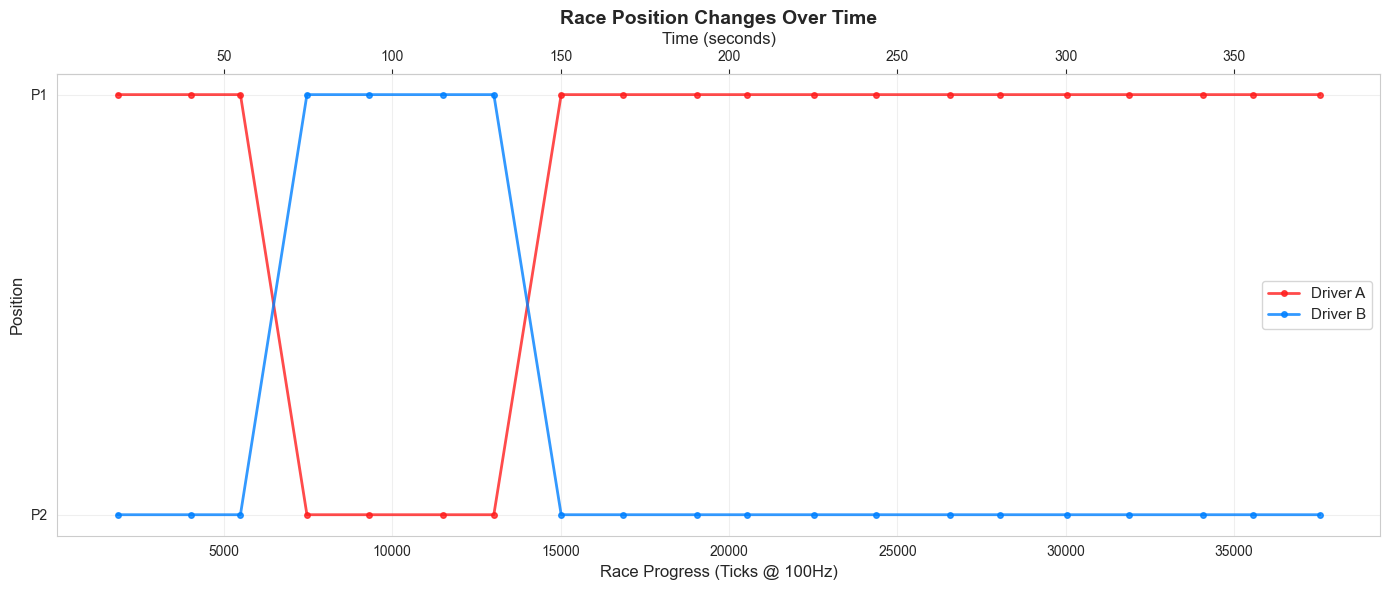


Total Position Changes: 2
Position changes tracked at 20 corner decision points


In [113]:
# Extract position data from history (at corner decision points)
ticks = []
driver_positions = {driver.name: [] for driver in simulator.drivers}

for state in simulator.history:
    ticks.append(state['tick'])
    for driver_data in state['drivers']:
        driver_positions[driver_data['name']].append(driver_data['position'])

# Plot position changes
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#FF1E1E', '#0080FF']  # F1-style colors
for i, (driver_name, positions) in enumerate(driver_positions.items()):
    ax.plot(ticks, positions, marker='o', linewidth=2, markersize=4, 
            label=driver_name, color=colors[i], alpha=0.8)

ax.set_xlabel('Race Progress (Ticks @ 100Hz)', fontsize=12)
ax.set_ylabel('Position', fontsize=12)
ax.set_title('Race Position Changes Over Time', fontsize=14, fontweight='bold')
ax.set_yticks([1, 2])
ax.set_yticklabels(['P1', 'P2'])
ax.invert_yaxis()  # P1 at top
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Add secondary x-axis showing time in seconds
ax2 = ax.secondary_xaxis('top', functions=(
    lambda x: x * 0.01, 
    lambda x: x / 0.01
))
ax2.set_xlabel('Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

# Count position changes
total_position_changes = sum(
    1 for i in range(1, len(driver_positions['Driver A'])) 
    if driver_positions['Driver A'][i] != driver_positions['Driver A'][i-1]
)
print(f"\nTotal Position Changes: {total_position_changes}")
print(f"Position changes tracked at {len(ticks)} corner decision points")

## 8. Visualisation: Gap Analysis

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

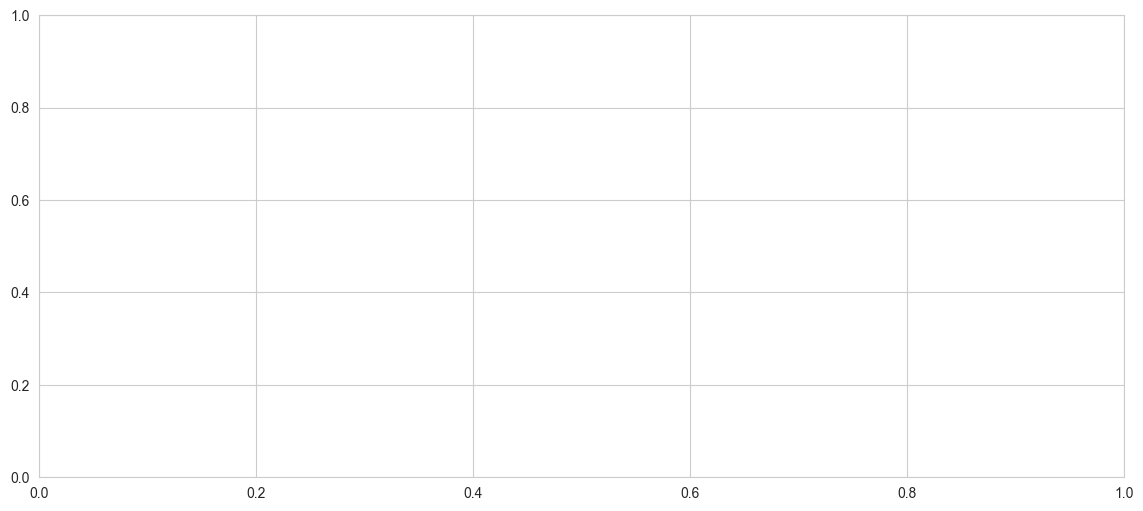

In [124]:
# Extract gap data
gaps = {driver.name: [] for driver in simulator.drivers}

for state in simulator.history:
    for driver_data in state['drivers']:
        if driver_data['gap_ahead'] is not None:
            gaps[driver_data['name']].append(abs(driver_data['gap_ahead']))
        else:
            gaps[driver_data['name']].append(0)  # Leader has 0 gap

# Plot gaps
fig, ax = plt.subplots(figsize=(14, 6))

for i, (driver_name, gap_data) in enumerate(gaps.items()):
    ax.plot(ticks, gap_data, linewidth=2, label=f"{driver_name} Gap to Leader", 
            color=colors[i], alpha=0.7)

ax.set_xlabel('Race Progress (Ticks @ 100Hz)', fontsize=12)
ax.set_ylabel('Gap to Leader (seconds)', fontsize=12)
ax.set_title('Gap Analysis: Distance Between Drivers', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Add secondary x-axis showing time in seconds
ax2 = ax.secondary_xaxis('top', functions=(
    lambda x: x * 0.01, 
    lambda x: x / 0.01
))
ax2.set_xlabel('Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

## 9. Visualisation: Cumulative Time Comparison

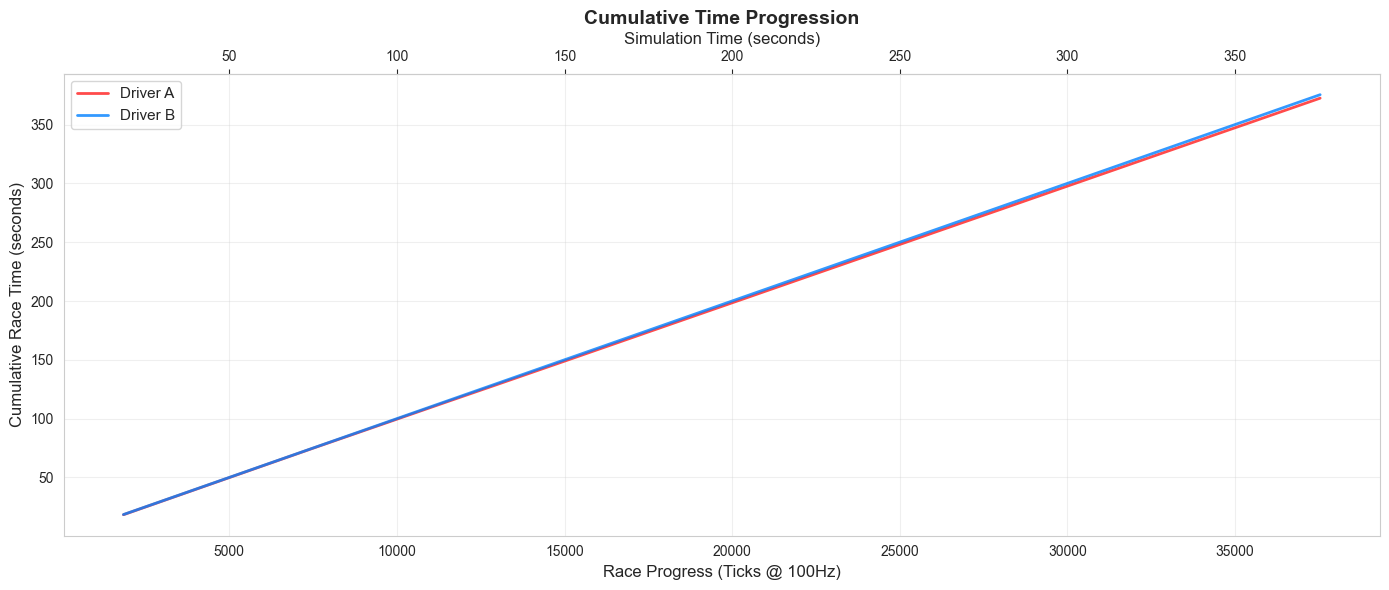

In [115]:
# Extract cumulative times
times = {driver.name: [] for driver in simulator.drivers}

for state in simulator.history:
    for driver_data in state['drivers']:
        times[driver_data['name']].append(driver_data['total_time'])

# Plot cumulative times
fig, ax = plt.subplots(figsize=(14, 6))

for i, (driver_name, time_data) in enumerate(times.items()):
    ax.plot(ticks, time_data, linewidth=2, label=driver_name, 
            color=colors[i], alpha=0.8)

ax.set_xlabel('Race Progress (Ticks @ 100Hz)', fontsize=12)
ax.set_ylabel('Cumulative Race Time (seconds)', fontsize=12)
ax.set_title('Cumulative Time Progression', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Add secondary x-axis showing time in seconds
ax2 = ax.secondary_xaxis('top', functions=(
    lambda x: x * 0.01, 
    lambda x: x / 0.01
))
ax2.set_xlabel('Simulation Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

## 10. Visualisation: Incident and Overtake Analysis

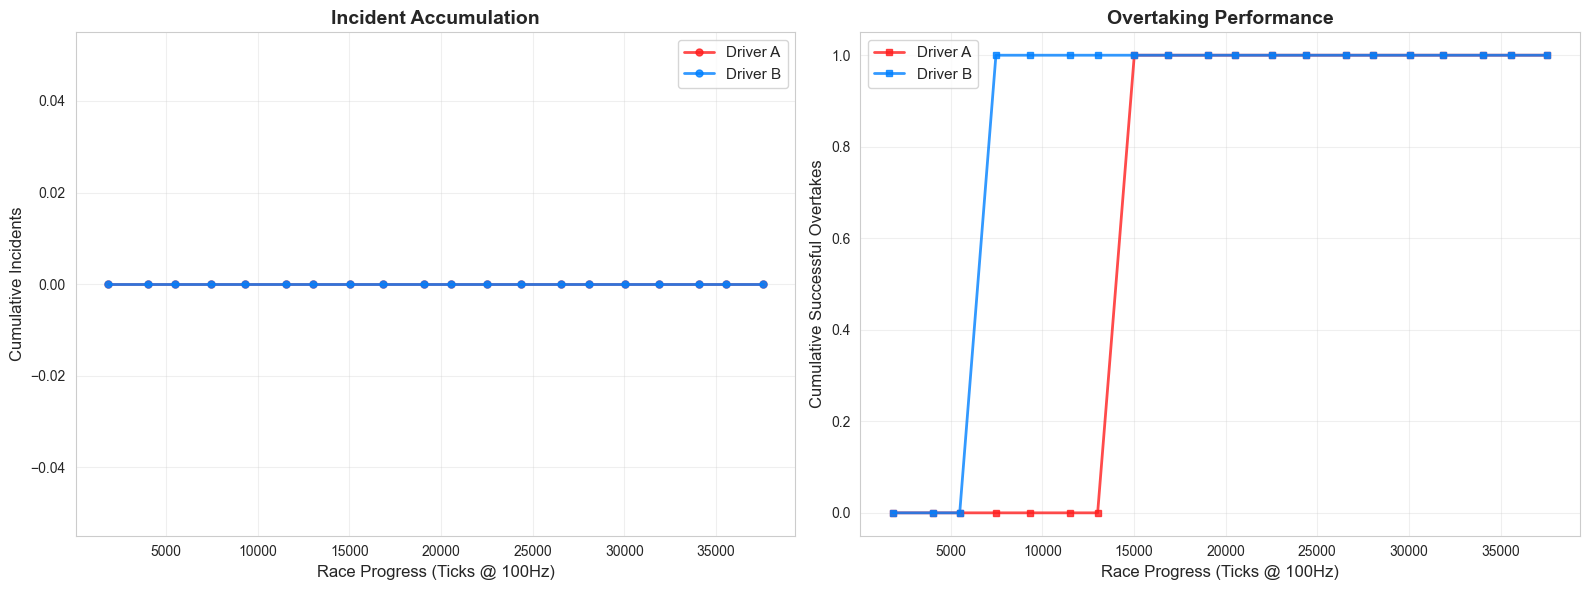

In [116]:
# Collect event statistics
incident_counts = {driver.name: [] for driver in simulator.drivers}
overtake_counts = {driver.name: [] for driver in simulator.drivers}

for state in simulator.history:
    for driver_data in state['drivers']:
        incident_counts[driver_data['name']].append(driver_data['incidents'])
        overtake_counts[driver_data['name']].append(driver_data['overtakes_made'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Incidents over time
for i, (driver_name, incidents) in enumerate(incident_counts.items()):
    ax1.plot(ticks, incidents, marker='o', linewidth=2, markersize=5,
             label=driver_name, color=colors[i], alpha=0.8)

ax1.set_xlabel('Race Progress (Ticks @ 100Hz)', fontsize=12)
ax1.set_ylabel('Cumulative Incidents', fontsize=12)
ax1.set_title('Incident Accumulation', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Overtakes over time
for i, (driver_name, overtakes) in enumerate(overtake_counts.items()):
    ax2.plot(ticks, overtakes, marker='s', linewidth=2, markersize=5,
             label=driver_name, color=colors[i], alpha=0.8)

ax2.set_xlabel('Race Progress (Ticks @ 100Hz)', fontsize=12)
ax2.set_ylabel('Cumulative Successful Overtakes', fontsize=12)
ax2.set_title('Overtaking Performance', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Strategy Comparison Summary

In [117]:
# Create comprehensive summary
summary_data = []

for driver in sorted(simulator.drivers, key=lambda d: d.position):
    summary_data.append({
        'Driver': driver.name,
        'Final Position': driver.position,
        'Total Time': f"{driver.total_time:.2f}s",
        'Incidents': driver.incidents,
        'Overtakes Made': driver.overtakes_made,
        'Overtakes Received': driver.overtakes_received,
        'Net Overtakes': driver.overtakes_made - driver.overtakes_received
    })

summary_df = pd.DataFrame(summary_data)

print("="*70)
print("FINAL RACE SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Determine winner
winner = sorted(simulator.drivers, key=lambda d: d.position)[0]
print(f"\n🏆 WINNER: {winner.name} (P{winner.position})")
print(f"   Total Time: {winner.total_time:.2f}s")
print(f"   Incidents: {winner.incidents}")
print(f"   Overtakes: {winner.overtakes_made}")

FINAL RACE SUMMARY
  Driver  Final Position Total Time  Incidents  Overtakes Made  Overtakes Received  Net Overtakes
Driver A               1    372.50s          0               1                   1              0
Driver B               2    375.45s          0               1                   1              0

🏆 WINNER: Driver A (P1)
   Total Time: 372.50s
   Incidents: 0
   Overtakes: 1


## 12. Demonstration: Fast Batch Simulation

The 100Hz tick system enables running thousands of simulations quickly for MARL training.

In [118]:
import time

# Run multiple races quickly
num_simulations = 100
print(f"Running {num_simulations} race simulations...")

start_time = time.time()
results_collection = []

for sim_num in range(num_simulations):
    # Create new simulator
    sim_track = RacingTrack()
    sim = RaceSimulator(sim_track, num_laps=5)
    sim.add_driver(driver_id=1, name="Driver A", starting_position=1)
    sim.add_driver(driver_id=2, name="Driver B", starting_position=2)
    
    # Create agents
    agent_a = AggressiveAgent(driver_id=1, name="Driver A")
    agent_b = AdaptiveAgent(driver_id=2, name="Driver B")
    
    # Run race
    while not sim.is_race_finished():
        actions = {}
        for driver in sim.drivers:
            corner = sim_track.get_corner(driver.corner_idx)
            if driver.driver_id == 1:
                action = agent_a.get_action(driver, corner)
            else:
                action = agent_b.get_action(driver, corner)
            actions[driver.driver_id] = action
        
        sim.simulate_corner(actions)
    
    # Collect results
    winner = sorted(sim.drivers, key=lambda d: d.position)[0]
    results_collection.append({
        'simulation': sim_num + 1,
        'winner': winner.name,
        'winner_time': winner.total_time,
        'total_ticks': sim.current_tick,
        'incidents_a': sim.drivers[0].incidents,
        'incidents_b': sim.drivers[1].incidents,
        'overtakes_a': sim.drivers[0].overtakes_made,
        'overtakes_b': sim.drivers[1].overtakes_made
    })

end_time = time.time()
elapsed = end_time - start_time

print(f"✓ Completed {num_simulations} simulations in {elapsed:.2f} seconds")
print(f"  Average: {(elapsed/num_simulations)*1000:.2f}ms per race")
print(f"  Rate: {num_simulations/elapsed:.1f} races/second")

# Analyze results
results_df = pd.DataFrame(results_collection)
print(f"\n{'='*60}")
print("BATCH SIMULATION RESULTS")
print(f"{'='*60}")
print(f"Driver A (Aggressive) wins: {(results_df['winner'] == 'Driver A').sum()}")
print(f"Driver B (Adaptive) wins: {(results_df['winner'] == 'Driver B').sum()}")
print(f"\nAverage Total Ticks per Race: {results_df['total_ticks'].mean():.0f}")
print(f"Average Race Duration: {(results_df['total_ticks'].mean() * 0.01):.2f}s")
print(f"\nAverage Incidents - Driver A: {results_df['incidents_a'].mean():.2f}")
print(f"Average Incidents - Driver B: {results_df['incidents_b'].mean():.2f}")
print(f"\nAverage Overtakes - Driver A: {results_df['overtakes_a'].mean():.2f}")
print(f"Average Overtakes - Driver B: {results_df['overtakes_b'].mean():.2f}")
print(f"{'='*60}")

Running 100 race simulations...
✓ Completed 100 simulations in 4.56 seconds
  Average: 45.62ms per race
  Rate: 21.9 races/second

BATCH SIMULATION RESULTS
Driver A (Aggressive) wins: 82
Driver B (Adaptive) wins: 18

Average Total Ticks per Race: 37597
Average Race Duration: 375.97s

Average Incidents - Driver A: 0.08
Average Incidents - Driver B: 0.09

Average Overtakes - Driver A: 1.75
Average Overtakes - Driver B: 1.93


## 13. Demonstration: Real-Time Tick Simulation (Optional)

For future real-time visualization, you can use the `.tick()` method to advance frame-by-frame.

In [119]:
# Example: Using tick() method for frame-by-frame simulation
# This is useful for real-time visualization in the future

rt_track = RacingTrack()
rt_sim = RaceSimulator(rt_track, num_laps=1)
rt_sim.add_driver(driver_id=1, name="Driver A", starting_position=1)
rt_sim.add_driver(driver_id=2, name="Driver B", starting_position=2)

# Initialize first corner
for driver in rt_sim.drivers:
    corner = rt_track.get_corner(driver.corner_idx)
    action = DriverAction(RiskLevel.NORMAL, False)
    result = rt_sim._start_corner(driver, action, corner)

print("Real-time tick simulation (first 10 ticks):")
print(f"{'Tick':<8} {'Driver A Ticks':<15} {'Driver B Ticks':<15} {'A Time':<10} {'B Time':<10}")
print("-" * 65)

for i in range(10):
    rt_sim.tick()
    progress = rt_sim.get_race_progress()
    
    print(f"{progress['current_tick']:<8} "
          f"{rt_sim.drivers[0].total_ticks:<15} "
          f"{rt_sim.drivers[1].total_ticks:<15} "
          f"{rt_sim.drivers[0].total_time:<10.2f} "
          f"{rt_sim.drivers[1].total_time:<10.2f}")

print("\n✓ This tick() method can be used for real-time visualization")
print("  Each tick advances 0.01 seconds of race time")
print("  Perfect for rendering at 100Hz or slower (e.g., 60Hz for display)")

Real-time tick simulation (first 10 ticks):
Tick     Driver A Ticks  Driver B Ticks  A Time     B Time    
-----------------------------------------------------------------
1        1               1               0.01       0.01      
2        2               2               0.02       0.02      
3        3               3               0.03       0.03      
4        4               4               0.04       0.04      
5        5               5               0.05       0.05      
6        6               6               0.06       0.06      
7        7               7               0.07       0.07      
8        8               8               0.08       0.08      
9        9               9               0.09       0.09      
10       10              10              0.10       0.10      

✓ This tick() method can be used for real-time visualization
  Each tick advances 0.01 seconds of race time
  Perfect for rendering at 100Hz or slower (e.g., 60Hz for display)
